# Chromosome segmentation for fish images

This notebook serves to detect the chromosomes in segmented FISH images for T-cells from mice.

---

## 0. Environmental setup

In [1]:
from skimage import filters, segmentation, exposure, color, morphology, restoration, feature, measure
import numpy as np
import tifffile
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
import SimpleITK as sitk
import os

# import the necessary packages
from __future__ import print_function
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from scipy import ndimage
import cv2

import sys

sys.path.append('..')

from src.utils.io import get_file_list, load_data_dict_from_pickle

In [2]:
def show_plane(ax, plane, cmap="gray", title=None):
    ax.imshow(plane, cmap=cmap)
    ax.axis("off")

    if title:
        ax.set_title(title)

        
def explore_slices(data, cmap="gray"):
    from ipywidgets import interact
    N = len(data)

    @interact(plane=(0, N - 1))
    def display_slice(plane=34):
        fig, ax = plt.subplots(figsize=(20, 5))

        show_plane(ax, data[plane], title="Plane {}".format(plane), cmap=cmap)

        plt.show()

    return display_slice

def explore_slices_2_samples(data, cmap="gray"):
    from ipywidgets import interact
    N = len(data[0])

    @interact(plane=(0, N - 1))
    def display_slice(plane=34):
        fig, ax = plt.subplots(figsize=(20, 5), nrows=1, ncols=2)

        show_plane(ax[0], data[0][plane], title="Plane {}".format(plane), cmap=cmap)
        show_plane(ax[1], data[1][plane], title='Plane {}'.format(plane), cmap=cmap)

        plt.show()

    return display_slice

def visualize_2d_image_grid(images):
    fig, ax = plt.subplots(ncols=5, nrows=len(images)//5 + len(images) % 5, figsize=[12,20])
    ax = ax.flatten()
    for i in range(len(images)):
        ax[i].imshow(cv2.resize(images[i], dsize=(128,128)))
        ax[i].axis('off')
        ax[i].set_aspect('auto')
    fig.subplots_adjust(hspace=0.0, wspace=0.0)
    plt.subplots_adjust(hspace=0.0, wspace=0.0)
    plt.show()

---

## 1. Read in data

In [3]:
file_list = get_file_list('/home/daniel/PycharmProjects/nuclear_segmentation/data/tcell_project/filtered/fish_ar_08_area_400sqmicron/filtered/')
cell_ids = list(range(90))
file_names = []
cells = []

for i in range(len(cell_ids)):
    file_names.append(os.path.basename(file_list[i]))
    cells.append(np.squeeze(tifffile.imread(file_list[cell_ids[i]])))

In [4]:
file_names[:90]

['t_cell_chr1_chr3_activated_2_s0_n0.tiff',
 't_cell_chr1_chr3_activated_3_s0_n0.tiff',
 't_cell_chr1_chr3_activated_3_s0_n1.tiff',
 't_cell_chr1_chr3_activated_5_s0_n0.tiff',
 't_cell_chr1_chr3_activated_5_s0_n1.tiff',
 't_cell_chr1_chr3_activated_6_s0_n0.tiff',
 't_cell_chr1_chr3_activated_6_s0_n1.tiff',
 't_cell_chr1_chr3_activated_7_s0_n2.tiff',
 't_cell_chr1_chr3_activated_8_s0_n0.tiff',
 't_cell_chr1_chr3_activated_9_s0_n0.tiff',
 't_cell_chr1_chr3_activated_10_s0_n0.tiff',
 't_cell_chr1_chr3_activated_10_s0_n1.tiff',
 't_cell_chr1_chr3_activated_10_s0_n2.tiff',
 't_cell_chr1_chr3_activated_11_s0_n0.tiff',
 't_cell_chr1_chr3_activated_11_s0_n1.tiff',
 't_cell_chr1_chr3_activated_12_s0_n0.tiff',
 't_cell_chr1_chr3_activated_13_s0_n0.tiff',
 't_cell_chr1_chr3_activated_14_s0_n0.tiff',
 't_cell_chr1_chr3_activated_15_s0_n0.tiff',
 't_cell_chr1_chr3_activated_16_s0_n0.tiff',
 't_cell_chr1_chr3_activated_16_s0_n1.tiff',
 't_cell_chr1_chr3_activated_19_s0_n1.tiff',
 't_cell_chr1_chr3_a

---

## 2. Chromosome detection in 2D

### 2.1. Raw data

#### Dapi images

In [5]:
explore_slices_2_samples([cells[0][:,0,:,:], cells[1][:,0,:,:]], cmap='magma')

interactive(children=(IntSlider(value=23, description='plane', max=23), Output()), _dom_classes=('widget-inter…

<function __main__.explore_slices_2_samples.<locals>.display_slice(plane=34)>

#### Chromosome 13

In [6]:
explore_slices_2_samples([filters.median(cells[0][:,1,:,:]), cells[1][:,1,:,:]], cmap='magma')

interactive(children=(IntSlider(value=23, description='plane', max=23), Output()), _dom_classes=('widget-inter…

<function __main__.explore_slices_2_samples.<locals>.display_slice(plane=34)>

#### Chromosome 17

In [7]:
explore_slices_2_samples([cells[0][:,2,:,:], cells[1][:,2,:,:]], cmap='seismic')

interactive(children=(IntSlider(value=23, description='plane', max=23), Output()), _dom_classes=('widget-inter…

<function __main__.explore_slices_2_samples.<locals>.display_slice(plane=34)>

### 2.2 2D detection

#### 2.2.1. Chromosome 13 & 17

In [8]:
dapi_max_z_projections = []
max_z_projections = []
for cell in cells:
    max_z_projections.append(cell[:,1,:,:].max(axis=0))
    dapi_max_z_projections.append(cell[:,0,:,:].max(axis=0))

In [9]:
binary_masks_chr13 = []

for proj in max_z_projections:
    filtered = filters.median(proj)
    t = np.mean(filtered) + np.std(filtered) * 1.96
    binary_mask = filtered > t
    binary_masks_chr13.append(binary_mask)

In [45]:
max_z_projections = []
for cell in cells:
    max_z_projections.append(np.array(cell[:,1,:,:]+cell[:,2,:,:]).max(axis=0))

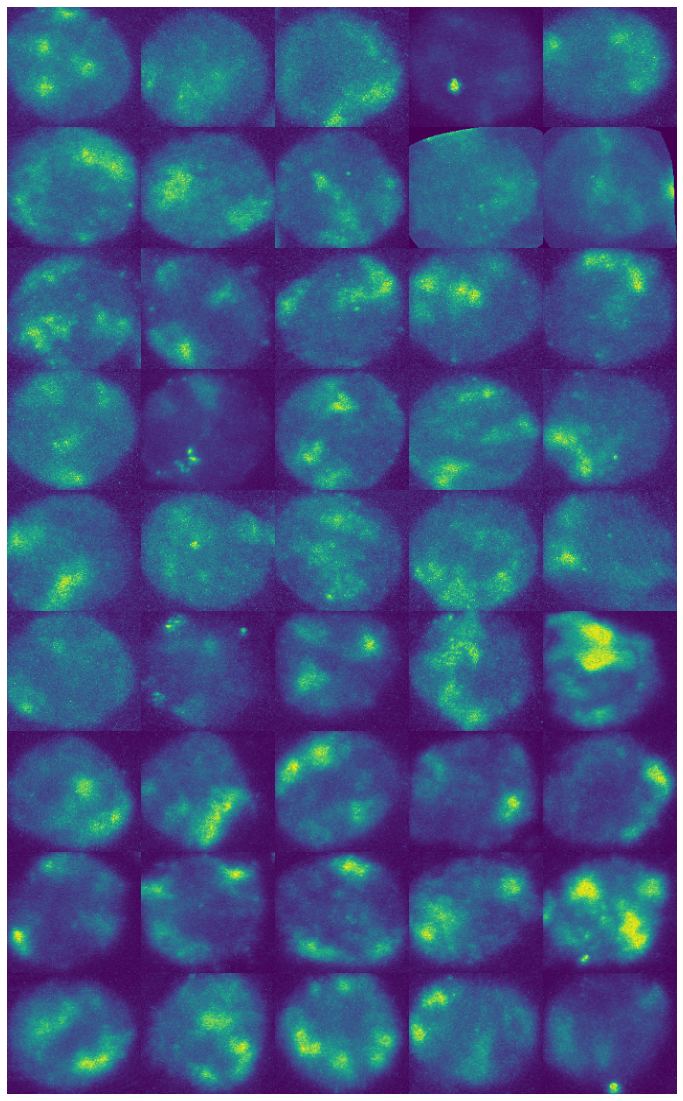

In [47]:
visualize_2d_image_grid(max_z_projections[:45])

In [88]:
binary_masks_chr17 = []

for proj in max_z_projections:
    filtered = filters.median(proj)
    t = np.mean(filtered) + np.std(filtered) * 1.96
    binary_mask = filtered > t
    binary_masks_chr17.append(binary_mask)

#### 2.2.2 Label images

In [99]:
labeled_masks = []
for i in range(len(binary_masks_chr13)):
    joint_mask = binary_masks_chr13[i].astype(np.uint8)*2+binary_masks_chr17[i].astype(np.uint8)
    labeled_masks.append(color.label2rgb(joint_mask, dapi_max_z_projections[i], bg_label=0, alpha=0.1))

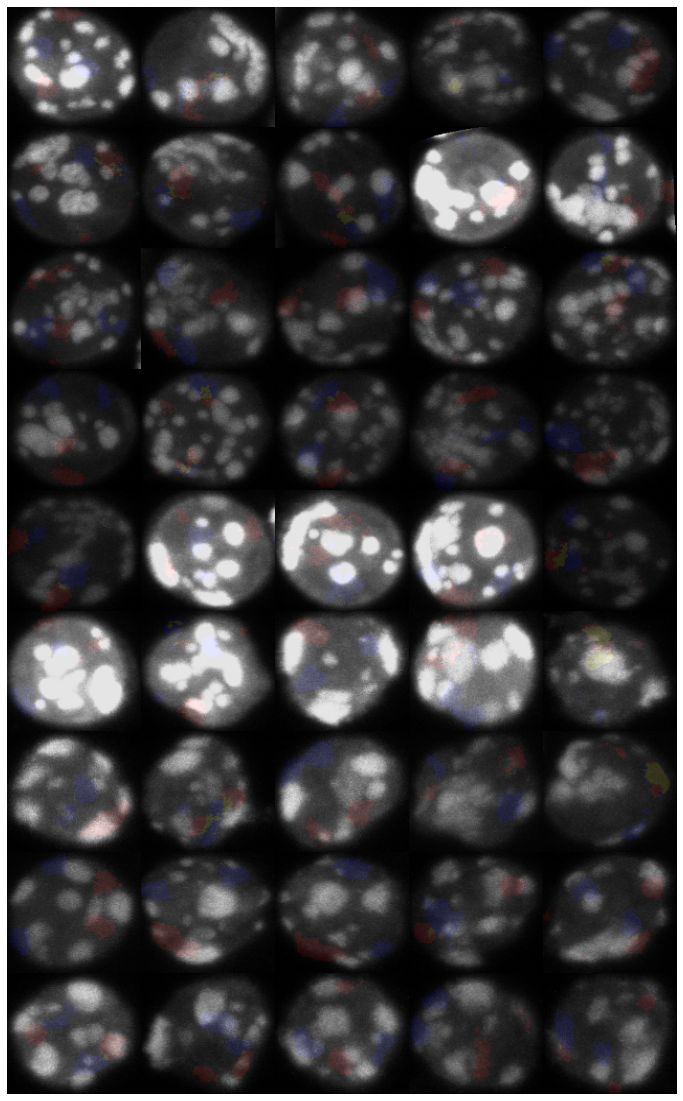

In [100]:
visualize_2d_image_grid(labeled_masks[:45])

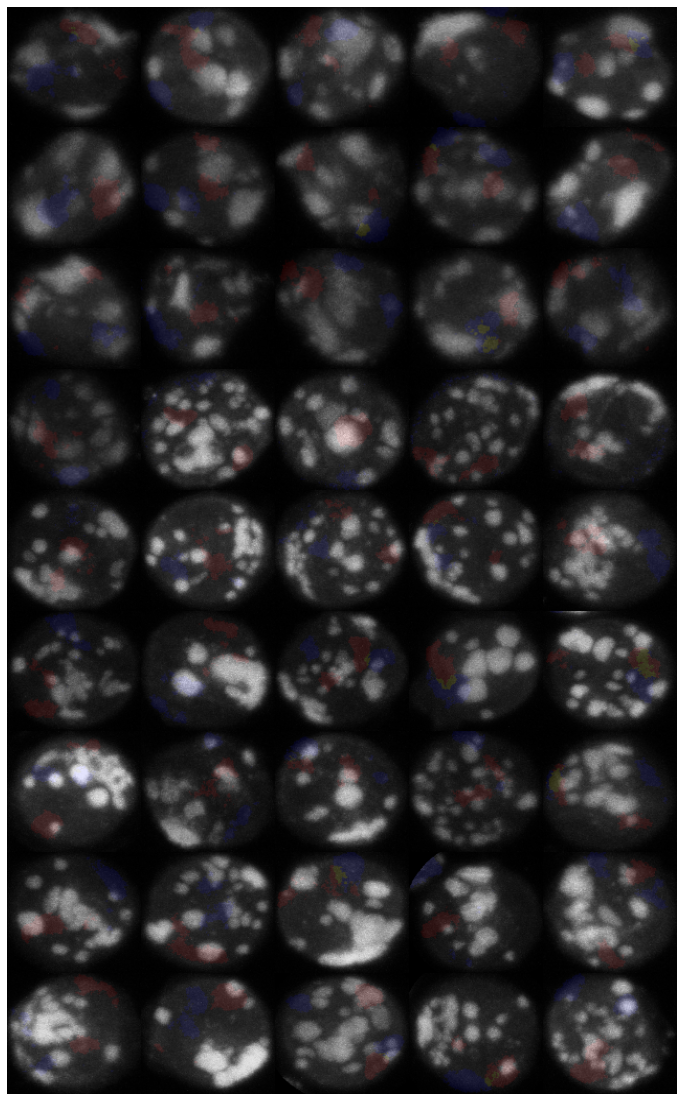

In [101]:
visualize_2d_image_grid(labeled_masks[45:90])